In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

# Grid and space SEPP with simulated data

We use a grid based histogram to estimate the background rate, but a "full" trigger.

Once we got all the normalisations correct, this works well.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime
import open_cp.data
import open_cp.sources.sepp as source_sepp
import open_cp.logger
open_cp.logger.log_to_true_stdout("sepp")
open_cp.logger.log_to_true_stdout("open_cp")
import sepp.sepp_grid
import sepp.sepp_grid_space

## The background sampler we'll use

In [3]:
class GridPoissonSampler(source_sepp.Sampler):
    def __init__(self, grid, rates, clustered=False):
        self._grid = grid
        self._rates = np.asarray(rates)
        assert (grid.yextent, grid.yextent) == self._rates.shape
        self._clustered = clustered
    
    def sample(self, start_time, end_time):
        points = []
        dt = end_time - start_time
        event_counts = np.random.poisson(dt * self._rates)
        for i in range(event_counts.shape[0]):
            for j in range(event_counts.shape[1]):
                times = np.random.random(event_counts[i,j]) * dt + start_time
                if self._clustered:
                    xcs = (0.4 + 0.2 * np.random.random(event_counts[i,j])) * self._grid.xsize
                    ycs = (0.4 + 0.2 * np.random.random(event_counts[i,j])) * self._grid.ysize
                else:
                    xcs = np.random.random(event_counts[i,j]) * self._grid.xsize
                    ycs = np.random.random(event_counts[i,j]) * self._grid.ysize
                xcs += self._grid.xoffset + j * self._grid.xsize
                ycs += self._grid.yoffset + i * self._grid.ysize
                for t, x, y in zip(times, xcs, ycs):
                    points.append([t,x,y])
        points = np.asarray(points).T
        return self._order_by_time(points)

In [4]:
grid = sepp.sepp_grid.ConcreteBoundedGrid(50, 50, 0, 0, 10, 10)
rates = np.random.random(size=(10,10)) / 10
bk_sampler = GridPoissonSampler(grid, rates)
tr_sampler = source_sepp.InhomogeneousPoissonFactors(source_sepp.Exponential(10, 0.5),
                source_sepp.GaussianSpaceSampler([0,0], [2,2], 0))
simulate = source_sepp.SelfExcitingPointProcess(bk_sampler, tr_sampler)

In [5]:
details = simulate.sample_with_details(0, 365)

## Triggering

Seems exponential in time and Gaussian in space, as expected

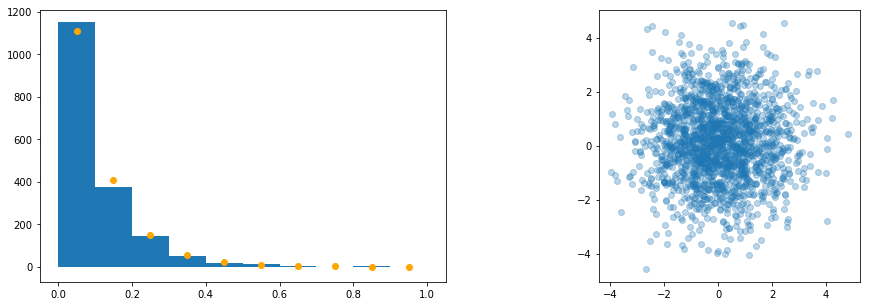

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(16,5))

axes[0].hist(details.trigger_deltas[0], bins=np.linspace(0,1,11))
x = np.linspace(0,1,11)
y = details.trigger_deltas.shape[1] * (np.exp(-10*x)[:-1] - np.exp(-10*x)[1:])
x += (x[1] - x[0])/2
axes[0].scatter(x[:-1], y, color="orange", zorder=10)
axes[1].scatter(*details.trigger_deltas[1:,], alpha=0.3)
axes[1].set_aspect(1)
None

In [7]:
print("Estimated omega =",
    1 / np.mean(details.trigger_deltas[0]) )
print("Estimated sigma^2 =",
    np.sum(details.trigger_deltas[1:]**2) / (2 * details.trigger_deltas.shape[1]) )

Estimated omega = 10.316566523
Estimated sigma^2 = 2.00330461245


## Background

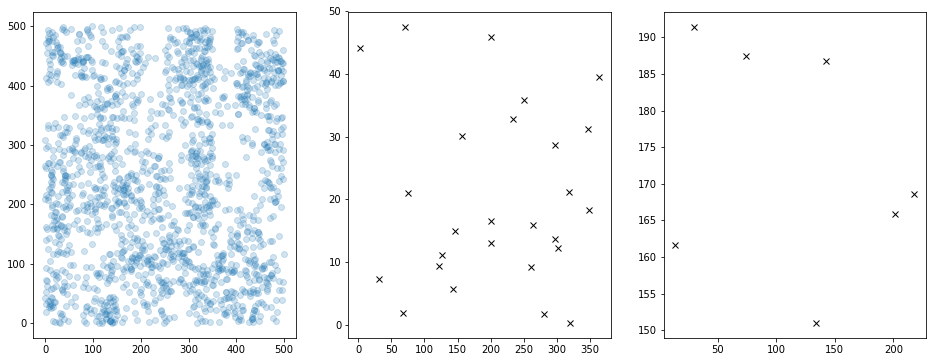

In [8]:
fig, axes = plt.subplots(ncols=3, figsize=(16,6))

xcs = details.backgrounds[1]
ycs = details.backgrounds[2]
axes[0].scatter(xcs, ycs, alpha=0.2)

m = (xcs < 50) & (ycs < 50)
times = details.backgrounds[0][m]
axes[1].scatter(times, xcs[m], marker="x", color="black", linewidth=1)

m = (xcs > 150) & (xcs < 200) & (ycs < 50)
times = details.backgrounds[0][m]
axes[2].scatter(times, xcs[m], marker="x", color="black", linewidth=1)

Compare the observed number of background events per grid cell against the expected number.

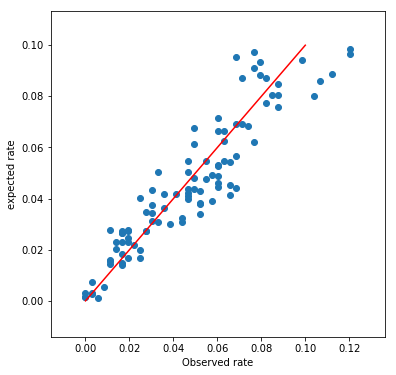

In [9]:
xg = np.floor(details.backgrounds[1] / 50).astype(np.int)
yg = np.floor(details.backgrounds[2] / 50).astype(np.int)
mu = np.zeros_like(rates)
for x, y in zip(xg, yg):
    mu[y,x] += 1
mu /= 365
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(mu.flatten(), rates.flatten())
ax.plot([0,0.1], [0,0.1], color="red")
ax.set(xlabel="Observed rate", ylabel="expected rate")
None

## Combined

Clip to the grid, and combine into a `TimedPoints` object

In [10]:
points = details.points

m = (points[1] >= 0) & (points[1] < 500) & (points[2] >= 0) & (points[2] < 500)
points = points[:,m]
points.shape, details.points.shape

((3, 3453), (3, 3461))

In [11]:
time_unit = source_sepp.make_time_unit(datetime.timedelta(days=1))
timed_points = source_sepp.scale_to_real_time(points, datetime.datetime(2017,1,1),
    time_unit)
timed_points.time_range

(numpy.datetime64('2017-01-01T04:53:01.951'),
 numpy.datetime64('2017-12-31T21:56:37.501'))

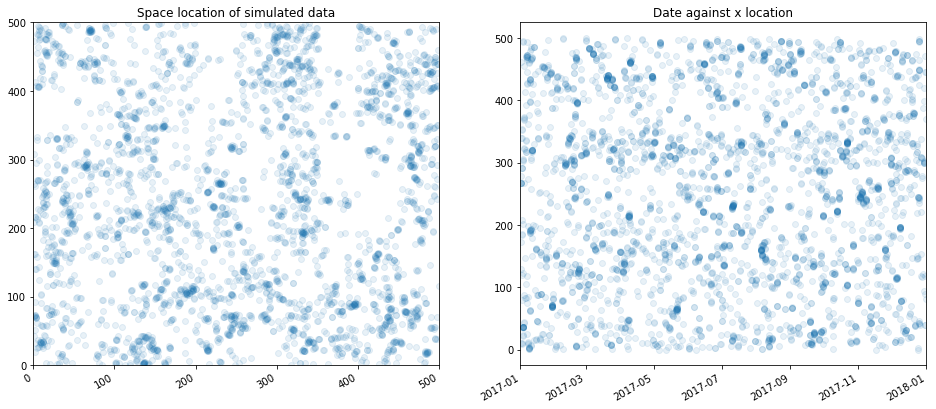

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(16,7))

ax[0].scatter(timed_points.xcoords, timed_points.ycoords, alpha=0.1)
ax[0].set_title("Space location of simulated data")
ax[0].set(xlim=[0,500], ylim=[0,500])

times = timed_points.times_datetime()
ax[1].scatter(times, timed_points.xcoords, alpha=0.1)
ax[1].set_xlim([datetime.datetime(2017,1,1), datetime.datetime(2018,1,1)])
ax[1].set_title("Date against x location")
fig.autofmt_xdate()
None

# Fit

In [13]:
trainer = sepp.sepp_grid_space.Trainer1(grid, 0.001)
trainer.data = timed_points
model = trainer.train(datetime.datetime(2018,1,1), iterations=1)

In [14]:
model

Model1(mu size=(10, 10), T=364.79650519675926, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.49162534336338864, omega=7.536260077807097, alpha=0.0, sigma^2=1.6154906504749913, r0=0.001

In [15]:
T, data = trainer.make_data(datetime.datetime(2018,1,1))
model = trainer.initial_model(T, data)
for _ in range(20):
    opt = sepp.sepp_grid_space.Optimiser1(model, data)
    model = opt.iterate()
    print(model)

Model1(mu size=(10, 10), T=364.79650519675926, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.49162534336338864, omega=7.536260077807097, alpha=0.0, sigma^2=1.6154906504749913, r0=0.001
Model1(mu size=(10, 10), T=364.79650519675926, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.5046866037226154, omega=9.859596141204186, alpha=0.0, sigma^2=1.9013033434283568, r0=0.001
Model1(mu size=(10, 10), T=364.79650519675926, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.5048141610263419, omega=10.256028585716466, alpha=0.0, sigma^2=1.9627229187052693, r0=0.001
Model1(mu size=(10, 10), T=364.79650519675926, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.5048020377420307, omega=10.31814128212898, alpha=0.0, sigma^2=1.9747844523380818, r0=0.001
Model1(mu size=(10, 10), T=364.79650519675926, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.504801151212603, omega=10.327897394482893, alpha=0.0, sigma^2=1.9770958143650628, r0=0.001
Model1(mu size=(10, 10), T=364.7965051

Note that the interpretation of the `mu` matrix is different from `sepp_grid`.  Now it is the (average) intensity in the relavant grid cell.  To get the background rate in the whole cell, we need to _integrate_ over the cell, which corresponds to multiplying by the cell area.

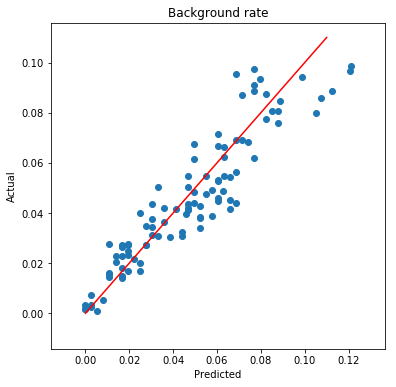

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(model.mu.flatten() * grid.xsize * grid.ysize, rates.flatten())
ax.plot([0,0.11], [0,0.11], color="red")
ax.set(xlabel="Predicted", ylabel="Actual", title="Background rate")
None

# With the actual triggering

**This will only work** if no simulated events fall outside of the grid.

Work out which are backgrounds, and what triggered what.

This shows that the optimisation step is "correct", modulo predicting what's a background, and what's triggered.

In [17]:
times = details.points[0]
assert np.max(np.abs(times - times[0] - data[0])) < 2e-8
np.testing.assert_allclose(details.points[1], data[1])
np.testing.assert_allclose(details.points[2], data[2])

ValueError: operands could not be broadcast together with shapes (3461,) (3453,) 

In [ ]:
def find_point(pt):
    m = np.sum((details.points - pt[:,None])**2, axis=0) < 1e-5
    hits = np.arange(len(m))[m]
    assert len(hits) == 1
    return hits[0]

background_indicies = [find_point(pt) for pt in details.backgrounds.T]

In [ ]:
pmatrix = np.zeros((details.points.shape[1], details.points.shape[1]))
for i in background_indicies:
    pmatrix[i,i] = 1

for pt, delta in zip(details.trigger_points.T, details.trigger_deltas.T):
    pt_index = find_point(pt)
    target_index = find_point(pt + delta)
    assert target_index not in background_indicies
    assert pt_index < target_index
    pmatrix[pt_index, target_index] = 1
    
for j in range(pmatrix.shape[1]):
    assert np.sum(pmatrix[:,j]) == 1

In [ ]:
opt = sepp.sepp_grid_space.Optimiser1(model, data)
opt.inject_pmatrix(pmatrix)
model = opt.iterate()

In [ ]:
model

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(model.mu.flatten() * grid.xsize * grid.ysize, rates.flatten())
ax.plot([0,0.11], [0,0.11], color="red")
ax.set(xlabel="Predicted", ylabel="Actual", title="Background rate")
None